In [ ]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import lightgbm as LGBMClassifier
import os
import seaborn  as sns


## LECTURA DEL DATASET

In [ ]:
df = pd.read_csv('/content/malicious_phish.csv') #leemos el dataset
print("Dataset: ", df.shape) #devuelve una tupla que es el numero de filas y columnas
df.head() #muestra las primeras 5 lineas del dataset


Dataset:  (651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


## ESTRUCTURA DEL DATASET

In [ ]:
df.type.value_counts() #devuelve los tipos y cuántos son de cada uno

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

## CARACTERÍSTICAS EXTRACCIÓN Y SELECCIÓN


## Expresiones regulares: Uso de IP
Estas nos permiten buscar patrones específicos dentro de cadenas de texto y realizar operaciones basadas en esos patrones.

In [ ]:
import re #modulo de expresiones regulares de python
def having_ip_address(url):#Función
    match = re.search( #busca un patron en la URL para buscar direcciones ipv4 o ipv6
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match: #si encuentra, regresa 1
        return 1
    else: #si no encuentra, regresa 0
        return 0
#Crea una nueva columna llamada use_of_ip
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))


## VERIFICAR SI ES ABNORMAL LA URL
Verificamos tiene diferentes palabras o algo que normlamente no está en las url comunes

In [ ]:
#Tener diferentes tipos de keywords o algo que no es normalmente visto en urls
from urllib.parse import urlparse # se utiliza para analizar (parsear) una URL dada y dividirla en sus componentes como esquema, red, ubicación, ruta, parámetros, consulta, fragmento, etc.

def abnormal_url(url):
  hostname = urlparse(url).hostname #de urlparse tomamos hostname
  hostname = str(hostname) #Convierte hostname en una cadena (string) si es necesario, para asegurarnos de que sea un tipo de datos compatible con re.search.
  match = re.search(hostname, url) #busca re.search apra buscar que hostname esté
  if match: #si si está
    return 1 #regresa1
  else:
    return 0 #sino, regresa 0
#utiliza apply para aplicar la función abnormal_url a cada elemento (i) en la columna 'url' del DataFrame df.
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

Una función lambda en Python es una función anónima y pequeña que se define sin un nombre mediante la palabra clave lambda. A diferencia de las funciones definidas con def, las funciones lambda se utilizan para expresiones simples que se evalúan y devuelven en una sola línea de código.

## ****no se usa** VERIFICAR SI ESTÁ INDEXADO EN GOOGLE
googlesearch-python nos ayuda para buscar un sitio en particular y para saber si está indexado en google, esto quiere decir, significa que una página web o contenido específico ha sido procesado y almacenado por el motor de búsqueda de Google para ser incluido en su índice.

In [ ]:
!pip install googlesearch-python

In [ ]:
from googlesearch import search #importamos search
def google_index(url): #le pasamos la url
  site = search(url, 5) #busca la url, hasta 5 resultados
  return 1 if site else 0 #devuelve 1 si si la encuentra y 0 si no
df['google_index'] = df['url'].apply(lambda i: google_index(i)) #aplicamos esta función a cada columna del dataset

## CONTAR LOS PUNTOS EN LA URL
La función devuelve el recuento de puntos dentro de la url

In [ ]:
def count_dot(url):#funcion y le pasamos url
  count_dot = url.count('.') #hacemos un count de los puntos
  return count_dot #devolvemos el recuento

df['count-dot'] = df['url'].apply(lambda i: count_dot(i)) #añadimos la columna al dataset
df.head() #mostramos las primeras 5 lineas del dataset

,url,type,use_of_ip,abnormal_url,google_index,count-dot
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


## RECUENTO DE PALABRAS CLAVE `www`, `@`

In [ ]:
def count_www(url):
  url.count('www')
  return url.count('www')
df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):
    return url.count('@')


df['count@'] = df['url'].apply(lambda i: count_atrate(i))

## NÚMERO DE DIRECTORIOS, dados por `/`

In [ ]:
def no_of_dir(url):
  urldir = urlparse(url).path
  return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

## NÚMERO DE INTEGRACIONES `//`

In [ ]:
def no_of_embed(url):
  urldir = urlparse(url).path
  return urldir.count('//')
df['count_embed_domain'] = df['url'].apply(lambda i: no_of_embed(i))

## SHORTENING SERVICE
Hay servicios donde acortan la url para hacerla más pequeña
La función lo sidentificará y dirá si son urls acortadas o no

In [ ]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0


df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

## CONTADOR DE `HTTPS` Y `HTTP`

In [ ]:
def count_https(url):
  return url.count('https')
df['count-https'] = df['url'].apply(lambda i: count_https(i))

def count_http(url):
  return url.count('http')
df['count-http'] = df['url'].apply(lambda i: count_http(i))

## CONTADOR DE `%`,` ?`,` - `, `=`
- Los % SON ESPACIOS
- ? normalmente un id


In [ ]:
def count_per(url):
  return url.count('%')
df['count%'] = df['url'].apply(lambda i: count_per(i))

def count_ques(url):
  return url.count('?')
df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
  return url.count('-')
df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
  return url.count('=')
df['count='] = df['url'].apply(lambda i: count_equal(i))


## LONGITUD DE LA URL

In [ ]:
def url_length(url):
  return len(str(url))

df['url_length'] = df['url'].apply(lambda i: url_length(i))

LONGITUD DEL HOSTNAME

In [ ]:
def hostname_length(url):
  return len(urlparse(url).netloc) #NETCLOC: Representa el nombre de host (hostname) y el número de puerto, si está presente, de la URL.

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))


## PALABRAS SOSPECHOSAS

In [ ]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

## CONTADOR DE DIGITOS Y DE LETRAS

In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['count-digits'] = df['url'].apply(lambda i: digit_count(i))

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['count-letters'] = df['url'].apply(lambda i: letter_count(i))

## TOP LEVEL DOMAIN, Y PRIMER DIRECTORIO

In [ ]:
!pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
from urllib.parse import urlparse
from tld import get_tld
import os.path

#Longitud del primer directorio
def fd_length(url):
    urlpath=urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
      return 0
df['fd_length'] = df['url'].apply(lambda i: fd_length(i))


#Longitud del top level domain
#crear una nueva columna llamada tld, que extrae el dominio superior y devuelve su longitud
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1
df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [ ]:
df = df.drop("tld", axis=1) #eliminamos la columna tld porque solo queremos valores numéricso

In [ ]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count-dot',
       'count-www', 'count@', 'count_dir', 'count_embed_domain', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

# DISTRIBUCIÓN
De todos los features o características que creamos, debemos de ver la distribución de cada uno de ellos.
Tmbién para saber si nuestros features son buenos

## Distribución de use_of_ip

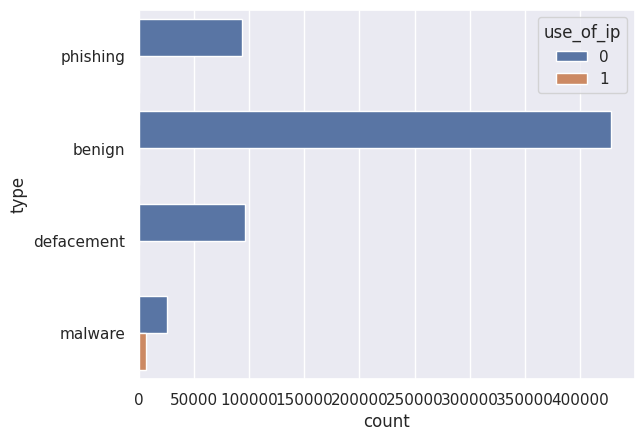

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df, hue="use_of_ip")

podemos decir que solo las url tipo malware tienen ip

## Distribución de abnormal_url

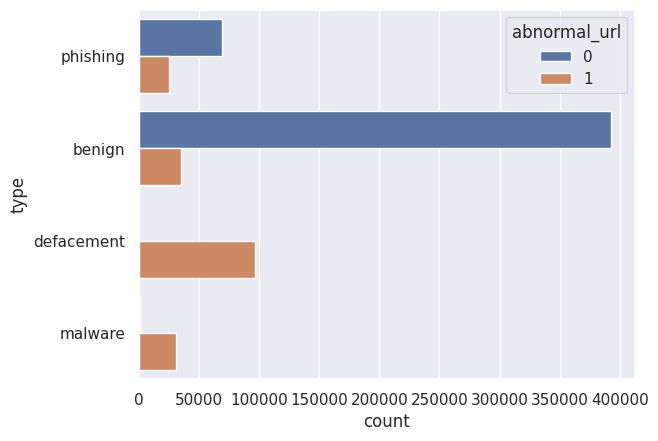

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df, hue="abnormal_url")

defacement tiene la mayor cantidad de url abnormales

Codificación del objetivo
nuestro objetivo es la columna tipo,vamos a convertir los nombres(secure,phishing,defacement,malware) en valores númericos

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df['type_code'] = lb_make.fit_transform(df['type'])
df['type_code'].value_counts()

type_code
0    428103
1     96457
3     94111
2     32520
Name: count, dtype: int64

# Creación de características y objetivo

In [ ]:
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count-dot', 'count-www', 'count@',
       'count_dir', 'count_embed_domain', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [ ]:
X.head()

,use_of_ip,abnormal_url,count-dot,count-www,count@,count_dir,count_embed_domain,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


# Training test SPLIT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=5)


- stratify garantiza que las proporciones de clases en y se mantengan en las divisiones de entrenamiento y prueba.
- test_size Especifica el tamaño del conjunto de prueba. Aquí, el 20% de los datos se utilizarán como conjunto de prueba y el 80% restante como conjunto de entrenamiento.
- shuffle Indica si se deben mezclar los datos antes de dividirlos. En este caso, se mezclan los datos antes de la división.
- random_state Es una semilla (seed) utilizada por el generador de números aleatorios para garantizar que los resultados sean reproducibles. Estableciendo este valor, aseguras que cada vez que ejecutes esta división, obtendrás la misma división de datos.


# Construcción del modelo

# 2. Decision Trees

              precision    recall  f1-score   support

      benign       0.97      0.98      0.97     85621
  defacement       0.98      0.99      0.98     19292
    phishing       0.95      0.94      0.95      6504
     malware       0.87      0.84      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.94      0.94      0.94    130239
weighted avg       0.96      0.96      0.96    130239

Accuracy: 0.958


Text(0.5, 32.249999999999986, 'Predicted Values')

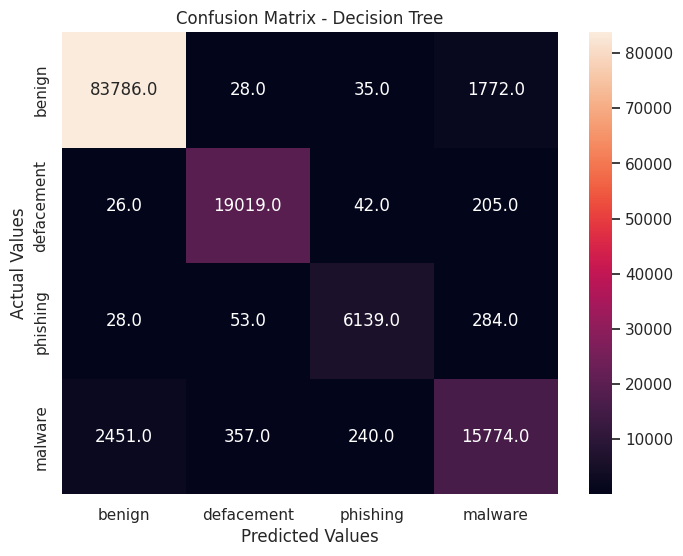

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(classification_report(y_test, y_pred_dt, target_names=['benign', 'defacement', 'phishing', 'malware']))

score_dt = metrics.accuracy_score(y_test, y_pred_dt)
print("Accuracy: %0.3f" % score_dt)


# 3. Random Forest Classifier

In [ ]:
!pip install scikit-learn
import sklearn.metrics as metrics

In [1]:
from sklearn.ensemble import RandomForestClassifier #importamos la biblioteca
#Creamos una instancia, se están construyendo 100 árboles, se considerará la raíz cuadrada del número total de características
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rf.fit(X_train, y_train) #utlizamos los datos de entrenamiento
y_pred_rf = rf.predict(X_test) #realizamos las predicciones
print(classification_report(y_test, y_pred_rf, target_names=['benign', 'defacement', 'phishing', 'malware']))

score = metrics.accuracy_score(y_test, y_pred_rf)
print("Accuracy: %0.3f" % score)

NameError: name 'X_train' is not defined

Una matriz de confusión es una herramienta fundamental en el campo de la clasificación supervisada que permite visualizar el desempeño de un modelo predictivo. Esta matriz muestra un resumen de la cantidad de predicciones correctas e incorrectas realizadas por un modelo en cada una de las clases de salida.
Las filas representan las clases reales y las columnas representan las clases predichas por el modelo. Cada celda en la matriz representa la cantidad de instancias que pertenecen a una determinada combinación de clase real y clase predicha.
La diagonal principal de la matriz (de arriba a la izquierda a abajo a la derecha) representa las predicciones correctas.
Los elementos fuera de la diagonal principal representan los errores de clasificación.

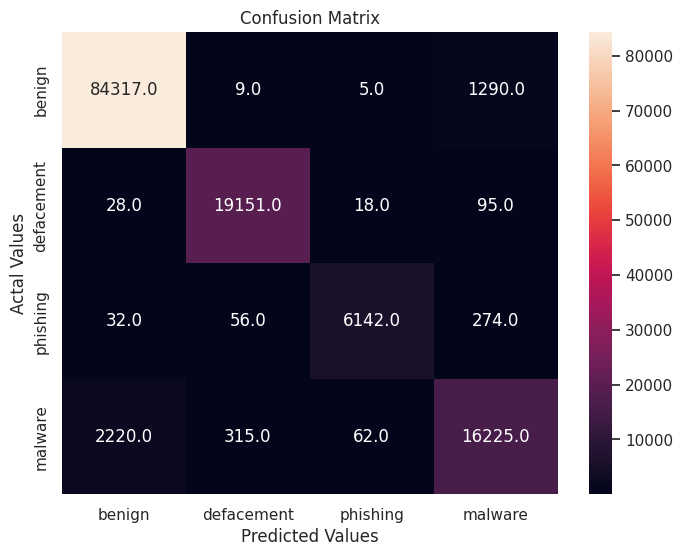

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement', 'phishing', 'malware'],
                     columns = ['benign', 'defacement', 'phishing', 'malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


# 4. XGBoost Classifier

In [ ]:
xgb_c = xgb.XGBClassifier(n_estimators=100)
xgb_c.fit(X_train, y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test, y_pred_x, target_names=['benign', 'defacement', 'phishing', 'malware']))

score = metrics.accuracy_score(y_test, y_pred_x)
print("Accuracy: %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.97      0.99      0.98     19292
    phishing       0.98      0.91      0.94      6504
     malware       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

Accuracy: 0.962


# * Light GBM Classifier

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 21
[LightGBM] [Info] Start training from score -0.419439
[LightGBM] [Info] Start training from score -1.909712
[LightGBM] [Info] Start training from score -2.996946
[LightGBM] [Info] Start training from score -1.934324
[LightGBM] [Warning] Unknown parameter: silent
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.98     19292
    phishing       0.97      0.90      0.93      6504
     malware       0.90      0.83      0.86     18822

    accuracy     

# Predicción

In [ ]:
def main(url):
  status = []

  status.append(having_ip_address(url))
  status.append(abnormal_url(url))
  status.append(count_dot(url))
  status.append(count_www(url))
  status.append(count_atrate(url))
  status.append(no_of_dir(url))
  status.append(no_of_embed(url))

  status.append(shortening_service(url))
  status.append(count_https(url))
  status.append(count_http(url))

  status.append(count_per(url))
  status.append(count_ques(url))
  status.append(count_hyphen(url))
  status.append(count_equal(url))

  status.append(url_length(url))
  status.append(hostname_length(url))
  status.append(suspicious_words(url))
  status.append(digit_count(url))
  status.append(letter_count(url))

  status.append(fd_length(url))
  status.append(tld_length(get_tld(url,fail_silently=True)))

  return status


def get_prediction_from_url(test_url):
  features_test = main(test_url)
  features_test = np.array(features_test).reshape(1, -1)

  pred = xgb_c.predict(features_test)
  if int(pred[0]) == 0:
    res = "SAFE"
    return res
  elif int(pred[0]) == 1.0:
    res = "DEFACEMENT"
    return res
  elif int(pred[0]) == 2.0:
    res = "PHISHING"
    return res
  elif int(pred[0]) == 3.0:
    res = "MALWARE"
    return res

urls = ['en.wikipedia.org/wiki/North_Dakota', 'instagram.com/', 'facebook.com/', 'www-smbc-card-com.cj412.com/', 'rldwnp1m.duckdns.org', 'ru1fjhvl.duckdns.org', 'www.pinterest.com.mx/', 'www.canva.com/', 'efan6ff.duckdns.org', 'wik.com.mx/']
for url in urls:
  print(get_prediction_from_url(url))

SAFE
SAFE
SAFE
MALWARE
MALWARE
MALWARE
SAFE
SAFE
MALWARE
SAFE
